<a href="https://colab.research.google.com/github/mjkellykim/GANinAction/blob/main/ch2_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# GAN in Action p57
# 책에서는 tensorflow 2.2.0 버전에서 테스트
# 현재 서버는 2.8.0 
# Multi-backend Keras는 공식적으로 2.4부터 지원하지 않음...(?)
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.datasets import mnist
import numpy as np

In [2]:
## Defining the key parameters
batch_size = 100
original_dim = 784 # MNIST 이미지의 높이X너비
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

In [3]:
## Defining Sampling Function
def sampling(args: tuple):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., 
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [4]:
## Defining Encoder
# input to the encoder 인코더 입력값 
x = Input(shape=(original_dim,), name='input')
# intermediate layer 중간층
h = Dense(intermediate_dim, activation='relu', name="encoding")(x) 
# defining the mean of the latent space 잠재 공간의 평균 정의
z_mean = Dense(latent_dim, name="mean")(h)
# defining the log variance of the latent space 잠재 공간의 로그 분산 정의
z_log_var = Dense(latent_dim, name="log-variance")(h)
# note that "output_shape" isn't nesassary with the Tensorflow backend
# 텐서플로 백엔드를 사용할 때는 output_shape가 꼭 필요하진 않음
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean,z_log_var]) 
# print out summery of what we just did
encoder = Model(x, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 784)]        0           []                               
                                                                                                  
 encoding (Dense)               (None, 256)          200960      ['input[0][0]']                  
                                                                                                  
 mean (Dense)                   (None, 2)            514         ['encoding[0][0]']               
                                                                                                  
 log-variance (Dense)           (None, 2)            514         ['encoding[0][0]']               
                                                                                            

In [5]:
## Defining Decoder
# input to the decoder 디코더 입력
input_decoder = Input(shape=(latent_dim,), name="decoder_input")
# taking the latent space to intermediate dimension 잠재 공간을 중간층의 차원으로 변환
decoder_h = Dense(intermediate_dim, activation='relu', name="decoder_h")(input_decoder)
# getting the mean from the original dimension 원본 차원으로 변환
x_decoded = Dense(original_dim, activation='sigmoid', name="flat_decoded")(decoder_h) 
# defining the decoder as a keras model
decoder = Model(input_decoder, x_decoded, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 decoder_h (Dense)           (None, 256)               768       
                                                                 
 flat_decoded (Dense)        (None, 784)               201488    
                                                                 
Total params: 202,256
Trainable params: 202,256
Non-trainable params: 0
_________________________________________________________________


In [6]:
## Variational AutoEncoder
# grab the output. Recall. that we need to grab the 3rd element our sample z
# 인코더의 출력을 디코더에서 사용, 인코더의 3번째 반환값이 z임!
output_combined = decoder(encoder(x)[2]) 
# link the input and the overall output 입력과 출력을 연결
vae = Model(x, output_combined) 
vae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 2),               201988    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 784)               202256    
                                                                 
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


In [7]:
## Defining Loss Function
kl_loss = -0.5 * K.sum(1 + z_log_var - K.exp(z_log_var) - K.square(z_mean), axis=-1)
vae.add_loss(K.mean(kl_loss) / 784.)
vae.compile(optimizer='rmsprop', loss="binary_crossentropy") # 모델 컴파일
vae.summary()
# 이진 교차 엔트로피 (Binary Cross-Entropy)와 쿨백-라이블러 발산(Kullback-Leibler Divergence; KL 발산)을 더해서 전체 손실을 만듦.
# * KL 발산은 분포간 차이를 측정함 - 두 분 포의 부피를 계산한 다음 겹치는 부분의 부피를 측정
# * 이진 교차 엔트로피는 클래스가 두 개인 분류 문제에서 사용하는 전형적인 손실 함수 중 하나

# 위 모델은 RMSprop를 이용하여 컴파일 하지만, Adam이나 SGD(Stochastic Gradient descent-확률적 경사 하강법) 사용 가능 
# 다른 딥러닝 시스템과 같이 오차를 역전파하여 파라미터 공간을 탐색함. 항상 경사 하강법을 사용하지만 Adam, SGD, RMSprop 이외를 사용하는 것은 드문 일

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 784)]        0           []                               
                                                                                                  
 encoder (Functional)           [(None, 2),          201988      ['input[0][0]']                  
                                 (None, 2),                                                       
                                 (None, 2)]                                                       
                                                                                                  
 decoder (Functional)           (None, 784)          202256      ['encoder[0][2]']                
                                                                                              

In [8]:
## 훈련/테스트 세트 분할 및 정규화
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

11501568/11490434 [==============================] - 0s 0us/step


In [9]:
## 실제처럼 정렬되지 않은 데이터셋을 위해 데이터를 섞는(shuffle) 옵션과 함께 fit 메서트 적용
vae.fit(x_train, x_train, 
        shuffle=True, 
        epochs=epochs, 
        batch_size=batch_size)

Epoch 1/50
600/600 [==============================] - 15s 23ms/step - loss: 0.2428
Epoch 2/50
600/600 [==============================] - 13s 21ms/step - loss: 0.2158
Epoch 3/50
600/600 [==============================] - 9s 15ms/step - loss: 0.2125
Epoch 4/50
600/600 [==============================] - 9s 15ms/step - loss: 0.2100
Epoch 5/50
600/600 [==============================] - 9s 15ms/step - loss: 0.2080
Epoch 6/50
600/600 [==============================] - 9s 15ms/step - loss: 0.2064
Epoch 7/50
600/600 [==============================] - 9s 15ms/step - loss: 0.2049
Epoch 8/50
600/600 [==============================] - 9s 15ms/step - loss: 0.2036
Epoch 9/50
600/600 [==============================] - 9s 15ms/step - loss: 0.2023
Epoch 10/50
600/600 [==============================] - 9s 15ms/step - loss: 0.2011
Epoch 11/50
600/600 [==============================] - 9s 15ms/step - loss: 0.2001
Epoch 12/50
600/600 [==============================] - 9s 15ms/step - loss: 0.1992
Epoch 13/50

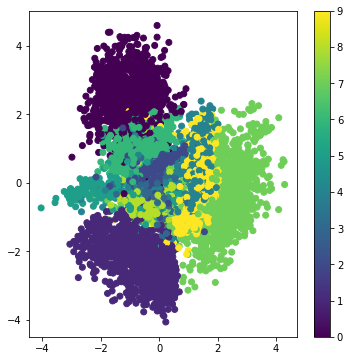

In [10]:
## display a 2D plot of the digit classes in the latent space
import matplotlib.pyplot as plt

x_test_encoded = encoder.predict(x_test, batch_size=batch_size)[0]
plt.figure(figsize=(6,6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test, cmap='viridis')
plt.colorbar()
plt.show()

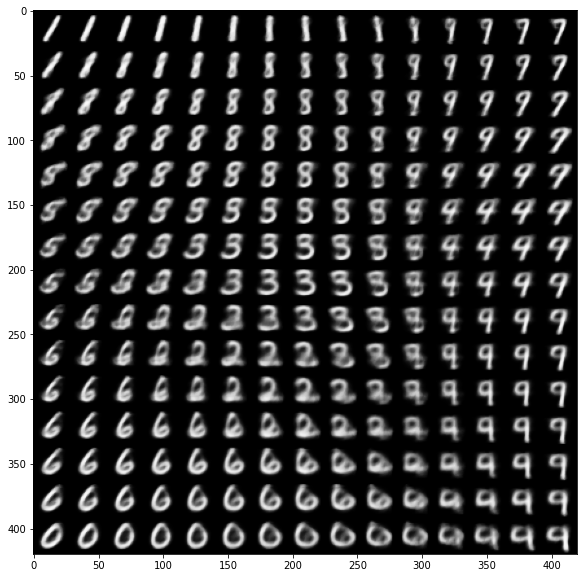

In [11]:
# display a 2D manifold of the digits
from scipy.stats import norm
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()